In [ ]:
# Prophet model for time series forecast
from prophet import Prophet
# Data processing
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
df1 = pd.read_csv("/content/forcasting.csv")
df1 = df1[["DATE","ModuleTemp","InverterTemp","AmbientAirTemp","Irradiance","Humidity","TodaysGenKwh"]]
df1=df1.round(3)

In [ ]:
df_test = df1[df1.index > 135]
df_train = df1[df1.index <= 135]
df=df_train.copy()
df_train.head()

,DATE,ModuleTemp,InverterTemp,AmbientAirTemp,Irradiance,Humidity,TodaysGenKwh
0,9/30/2019,21.005,30.385,21.970,0.000,100.000,0.00
1,10/1/2019,22.906,27.950,22.775,56.223,97.570,108.45
2,10/2/2019,41.990,40.432,29.398,475.247,69.694,121.25
3,10/3/2019,22.226,37.301,24.172,-1.394,91.581,0.00
4,10/5/2019,29.417,41.386,25.187,192.635,80.837,128.15


In [ ]:
df.describe()

,ModuleTemp,InverterTemp,AmbientAirTemp,Irradiance,Humidity,TodaysGenKwh
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,23.529169,35.416809,20.305912,200.026544,63.063250,93.992772
std,6.187057,5.189878,4.917860,77.722176,18.710684,29.732017
min,6.295000,21.975000,9.789000,-3.000000,20.267000,0.000000
25%,18.377750,31.456000,16.295250,162.901500,48.192250,81.895750
50%,23.066000,35.370000,20.170000,205.011500,64.861000,102.242000
75%,28.696750,39.806250,24.492750,242.577750,77.053750,113.904000
max,41.990000,46.313000,30.043000,475.247000,100.000000,130.883000


In [ ]:
df_train = df_train.rename(columns={'TodaysGenKwh': 'y', 'DATE':'ds'})
df_train['y_orig'] = df_train['y'] # to save a copy of the original data..you'll see why shortly. 
df_train['y'] = np.log(df_train['y'])
df_train=df_train.replace([np.inf, -np.inf], 0)

model_new = Prophet(daily_seasonality=False,
                    weekly_seasonality=False,
                    yearly_seasonality=True) #instantiate Prophet
model_new.add_regressor('Humidity')
model_new.add_regressor('Irradiance')
model_new.add_regressor('AmbientAirTemp')
model_new.add_regressor('ModuleTemp')
model_new.add_regressor('InverterTemp')

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
model_new.fit(df_train)

''' 'year': 'A',
        'quarter': 'Q',
        'month': 'M',
        'day': 'D',
        'hour': 'H',
        'minute': 'T',
        'second': 'S',
        'millisecond': 'L',
        'microsecond': 'U',
        'nanosecond': 'N'}
'''

#future_data = model.make_future_dataframe(periods=6, freq = 'H')
future_data = model_new.make_future_dataframe(periods=1000, freq = 'D')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxu4z10x3/ard6t5gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxu4z10x3/6670iyrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49913', 'data', 'file=/tmp/tmpxu4z10x3/ard6t5gn.json', 'init=/tmp/tmpxu4z10x3/6670iyrw.json', 'output', 'file=/tmp/tmpxu4z10x3/prophet_model7jp6kccm/prophet_model-20230302145249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:52:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:52:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_data.head(5)

,ds
0,2019-09-30
1,2019-10-01
2,2019-10-02
3,2019-10-03
4,2019-10-05


In [ ]:
df=df.append(df_test)
df = df.rename(columns={'TodaysGenKwh': 'y', 'DATE':'ds'})
future_data=df[['ds',"ModuleTemp","InverterTemp", 'AmbientAirTemp', 'Irradiance',"Humidity"]]
				

In [ ]:
future_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 177
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ds              178 non-null    object 
 1   ModuleTemp      178 non-null    float64
 2   InverterTemp    178 non-null    float64
 3   AmbientAirTemp  178 non-null    float64
 4   Irradiance      178 non-null    float64
 5   Humidity        178 non-null    float64
dtypes: float64(5), object(1)
memory usage: 9.7+ KB


In [ ]:
forecast_data = model_new.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
173,2020-05-28,6.943342,6.181557,7.674934
174,2020-05-29,5.346845,4.559716,6.094279
175,2020-05-30,7.212962,6.490726,8.073194
176,2020-05-31,7.282092,6.488495,8.084813
177,2020-06-01,5.031833,4.233715,5.787404


In [ ]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,AmbientAirTemp,AmbientAirTemp_lower,AmbientAirTemp_upper,Humidity,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-30,1.458635,1.126429,2.703294,1.458635,1.458635,-0.450752,-0.450752,-0.450752,-0.145908,...,-1.286250,-1.286250,-1.286250,1.755545,1.755545,1.755545,0.0,0.0,0.0,1.927930
1,2019-10-01,1.482258,1.447551,2.996414,1.482258,1.482258,-0.668803,-0.668803,-0.668803,-0.136309,...,-1.017138,-1.017138,-1.017138,1.769712,1.769712,1.769712,0.0,0.0,0.0,2.234832
2,2019-10-02,1.505880,4.746771,6.291561,1.505880,1.505880,-2.462779,-2.462779,-2.462779,-0.026193,...,2.253021,2.253021,2.253021,1.776421,1.776421,1.776421,0.0,0.0,0.0,5.535322
3,2019-10-03,1.529502,0.990120,2.590682,1.529502,1.529502,-1.047209,-1.047209,-1.047209,-0.112651,...,-1.506535,-1.506535,-1.506535,1.777412,1.777412,1.777412,0.0,0.0,0.0,1.800380
4,2019-10-05,1.576746,2.634733,4.198072,1.576746,1.576746,-1.322143,-1.322143,-1.322143,-0.070210,...,0.129217,0.129217,0.129217,1.769075,1.769075,1.769075,0.0,0.0,0.0,3.475039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2020-05-28,7.151591,6.181557,7.674934,7.151591,7.151591,-4.061186,-4.061186,-4.061186,0.102130,...,0.162649,0.162649,0.162649,-0.370898,-0.370898,-0.370898,0.0,0.0,0.0,6.943342
174,2020-05-29,7.175213,4.559716,6.094279,7.175213,7.175213,-3.499129,-3.499129,-3.499129,0.081367,...,-1.381053,-1.381053,-1.381053,-0.447316,-0.447316,-0.447316,0.0,0.0,0.0,5.346845
175,2020-05-30,7.198836,6.490726,8.073194,7.198836,7.198836,-3.684134,-3.684134,-3.684134,0.086740,...,0.545057,0.545057,0.545057,-0.530930,-0.530930,-0.530930,0.0,0.0,0.0,7.212962
176,2020-05-31,7.222458,6.488495,8.084813,7.222458,7.222458,-3.304915,-3.304915,-3.304915,0.093028,...,0.679488,0.679488,0.679488,-0.619854,-0.619854,-0.619854,0.0,0.0,0.0,7.282092


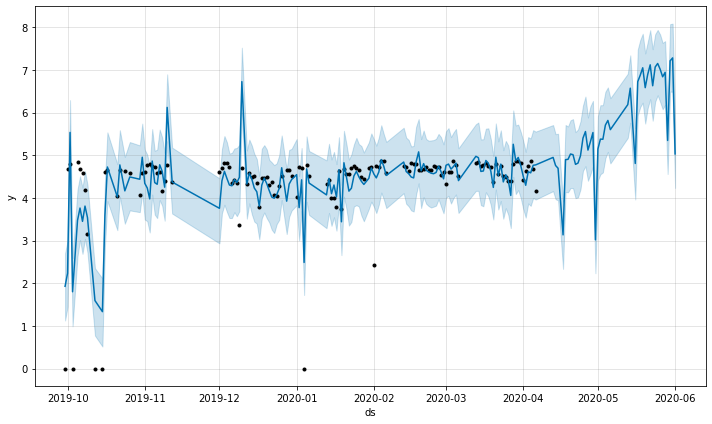

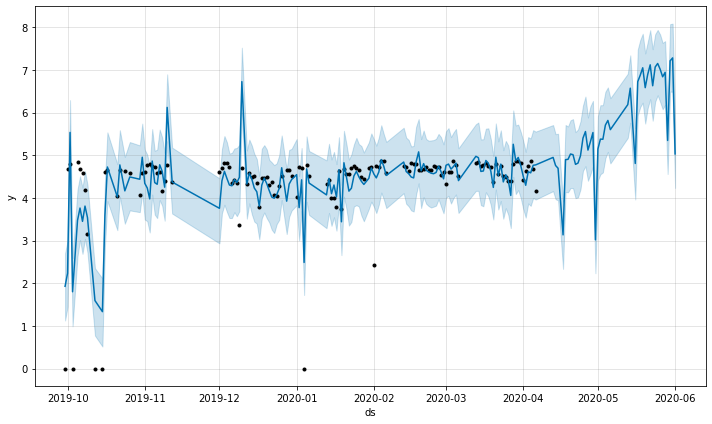

In [ ]:
model_new.plot(forecast_data)

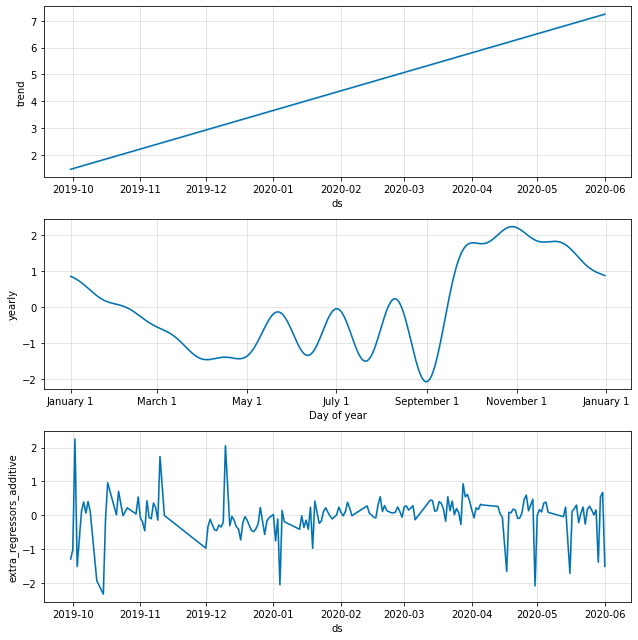

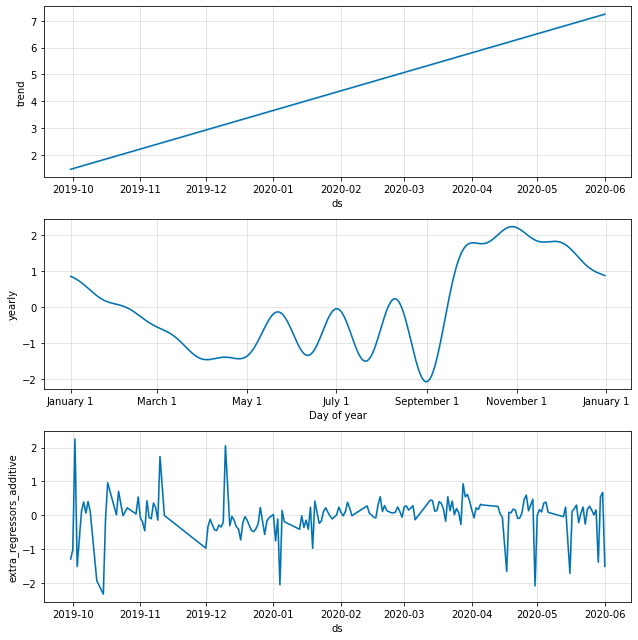

In [ ]:
model_new.plot_components(forecast_data)

In [ ]:
from sklearn import metrics
from sklearn.metrics import *
def hmetrics(x,y):
    
    print("The model performance for testing set")
    print("------------------------------------------------")
    z=['r2_score','mean_absolute_error',\
       'mean_squared_error','mean_squared_log_error',\
       'mean_absolute_percentage_error',\
       'median_absolute_error','max_error',\
       'explained_variance_score','mean_poisson_deviance','d2_tweedie_score']\
       #'mean_gamma_deviance','d2_absolute_error_score',\
       #'d2_pinball_score',
    
    z0 = metrics.r2_score(x, y)
    z1 = metrics.mean_absolute_error(x, y)
    z2 = metrics.mean_squared_error(x, y)
    z3 = metrics.mean_squared_log_error(x, y)
    z4 = metrics.mean_absolute_percentage_error(x, y)
    z5 = metrics.median_absolute_error(x, y)
    z6 = metrics.max_error(x, y)
    z7 = metrics.explained_variance_score(x, y)
    z8 = metrics.mean_poisson_deviance(x, y)
    #z9 = metrics.mean_gamma_deviance(x, y)
    #z10 = metrics.d2_absolute_error_score(x, y)
    #z11 = metrics.d2_pinball_score(x, y)
    z12 = metrics.d2_tweedie_score(x, y)
    s = [z0,z1,z2,z3,z4,z5,z6,z7,z8,z12]
    metrics_m = pd.DataFrame({'error/score': z,'value': s})
    return metrics_m
dfm2 = forecast_data.copy()
dfm2=dfm2[dfm2['ds']>'4/6/2020']
dfm2=dfm2[dfm2["ds"]<="2020-06-01"]
mx3 = hmetrics(df_test['TodaysGenKwh'], dfm2['yhat'])
mx3

The model performance for testing set
------------------------------------------------


,error/score,value
0,r2_score,-5.912624e+00
1,mean_absolute_error,9.395345e+01
2,mean_squared_error,1.004427e+04
3,mean_squared_log_error,7.224279e+00
4,mean_absolute_percentage_error,2.287917e+15
5,median_absolute_error,1.051716e+02
6,max_error,1.224764e+02
7,explained_variance_score,3.174558e-02
8,mean_poisson_deviance,3.964706e+02
9,d2_tweedie_score,-5.912624e+00
